In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 预测模式
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        # 训练模式
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 全连接层， 计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 卷积层， 在通道维上计算均值和方差
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
            
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

In [3]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.ones(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9
        )
        
        return Y

In [4]:
# 使用批量规范化层的LeNet
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    BatchNorm(6, num_dims=4),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    BatchNorm(16, num_dims=4),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    BatchNorm(120, num_dims=2),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    BatchNorm(84, num_dims=2),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [5]:
X = torch.rand(size=(1, 1, 28, 28))

for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
BatchNorm output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
BatchNorm output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
BatchNorm output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
BatchNorm output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [6]:
lr, num_epochs, batch_size = 1.0, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

loss 0.242, train acc 0.909, test acc 0.870
22899.3 examples/sec on cuda:0


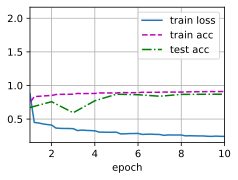

In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [10]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.6903, 1.4911, 3.3211, 0.2972, 0.6477, 4.8862], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([3.2063, 0.8435, 1.7153, 1.8001, 1.8513, 4.3969], device='cuda:0',
        grad_fn=<ViewBackward>))

In [11]:
# 简明实现

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.BatchNorm2d(6),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.BatchNorm2d(16),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.BatchNorm1d(120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.BatchNorm1d(84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.229, train acc 0.915, test acc 0.884
38446.3 examples/sec on cuda:0


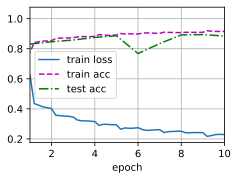

In [12]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())